<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fastai3_lesson3_head_pose_regression_%26_coordconv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision import *

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path

PosixPath('/root/.fastai/data/biwi_head_pose')

In [6]:
!ls {path}

01	04	07	10	13	16	19	22	io_sample.cpp
01.obj	04.obj	07.obj	10.obj	13.obj	16.obj	19.obj	22.obj	readme.txt
02	05	08	11	14	17	20	23
02.obj	05.obj	08.obj	11.obj	14.obj	17.obj	20.obj	23.obj
03	06	09	12	15	18	21	24
03.obj	06.obj	09.obj	12.obj	15.obj	18.obj	21.obj	24.obj


In [7]:
"""In each folder, two .cal files contain calibration information for the depth and the color camera, 
e.g., the intrinsic camera matrix of the depth camera and the global rotation and translation to the rgb camera.
This information can be used to align the RGB and depth data. Please note that the calibration is not the same for each sequence.
"""
!ls {path}/01/*.cal

/root/.fastai/data/biwi_head_pose/01/depth.cal
/root/.fastai/data/biwi_head_pose/01/rgb.cal


In [8]:
"""For each frame, a _rgb.png and a _depth.bin files are provided, containing color and depth data.
The depth is already segmented (the background is removed using a threshold on the distance)

The .txt files encode the rotation as a matrix"""
!ls {path}/01/frame_00003*

/root/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt
/root/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg


In [9]:
!head {path}/01/rgb.cal

517.679 0 320 
0 517.679 240.5 
0 0 1 

0 0 0 0 

0.999947 0.00432361 0.00929419 
-0.00446314 0.999877 0.0150443 
-0.009228 -0.015085 0.999844 



In [10]:
!head {path}/01/depth.cal

575.816 0 320 
0 575.816 240 
0 0 1 

0 0 0 0 

1 0 0 
0 1 0 
0 0 1 



In [11]:
# Please note that the calibration is not the same for each sequence.
!head -n3 {path}/22/rgb.cal

505.265 0 320 
0 505.265 240.5 
0 0 1 


In [12]:
!find {path} -name *.bin | wc -l

0


In [13]:
# The _pose.txt and _pose.bin files contain the ground truth information, i.e., the location of the center of the head in 3D and the head rotation.
!cat {path}/01/frame_00003_pose.txt

0.997978 0.0272944 0.0574071 
-0.0346956 0.990621 0.132163 
-0.0532613 -0.133887 0.989564 

51.9358 38.2631 881.756 



In [0]:
def convert_biwi_to_screen(cal, coords):  
  z_camera = coords[2]

  screen_coords = cal @ (np.array(coords) / z_camera)

  y_screen = screen_coords[1]
  x_screen = screen_coords[0]
  return tensor([y_screen, x_screen])

def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

def get_center_by_filename(filename):
  # Note to self: original notebook used the same calibration for all classes, while there are some minor differences
  # TODO: I think I should be using rgb.cal instead :/
  parent_folder = (path/filename).parent
  camera_calibration = np.genfromtxt(path/parent_folder/'depth.cal', skip_footer=6)
  center = np.genfromtxt(img2txt_name(filename), skip_header=3)
  return convert_biwi_to_screen(camera_calibration, center)

def get_ip(img, pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [15]:
!cat {path}/01/frame_00003_pose.txt

0.997978 0.0272944 0.0574071 
-0.0346956 0.990621 0.132163 
-0.0532613 -0.133887 0.989564 

51.9358 38.2631 881.756 



In [16]:
fname = '09/frame_00667_rgb.jpg'
get_center_by_filename(fname)

tensor([266.0395, 440.7754])

In [0]:
img = open_image(path/fname)

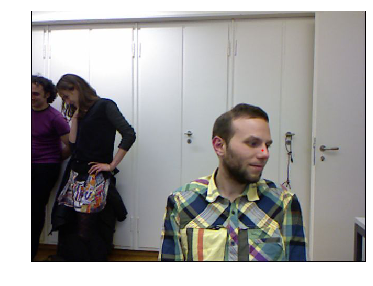

In [18]:
y = get_ip(img, get_center_by_filename(fname))
img.show(y=y, figsize=(6,6))

In [19]:
item_list = PointsItemList.from_folder(path)
item_list

PointsItemList (15678 items)
Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640)
Path: /root/.fastai/data/biwi_head_pose

In [20]:
# Note to self: this will yield empty sets
#item_list.split_by_folder(train=['01'], valid=['22'])
import pdb
split_list = item_list.split_by_valid_func(lambda file: file.parent.name == '13')
split_list

ItemLists;

Train: PointsItemList (15193 items)
Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640)
Path: /root/.fastai/data/biwi_head_pose;

Valid: PointsItemList (485 items)
Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640)
Path: /root/.fastai/data/biwi_head_pose;

Test: None

In [21]:
label_list = split_list.label_from_func(get_center_by_filename)
label_list

LabelLists;

Train: LabelList (15193 items)
x: PointsItemList
Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640)
y: PointsLabelList
ImagePoints (480, 640),ImagePoints (480, 640),ImagePoints (480, 640),ImagePoints (480, 640),ImagePoints (480, 640)
Path: /root/.fastai/data/biwi_head_pose;

Valid: LabelList (485 items)
x: PointsItemList
Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640),Image (3, 480, 640)
y: PointsLabelList
ImagePoints (480, 640),ImagePoints (480, 640),ImagePoints (480, 640),ImagePoints (480, 640),ImagePoints (480, 640)
Path: /root/.fastai/data/biwi_head_pose;

Test: None

In [22]:
tfms = get_transforms()
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0

In [0]:
bs = 64
# Note to self: I've forgot to transform y
# Note to self: orign size images won't fit with this batch size
data = label_list.transform(tfms, size=(120, 160), tfm_y=True).databunch(bs=bs).normalize(imagenet_stats)

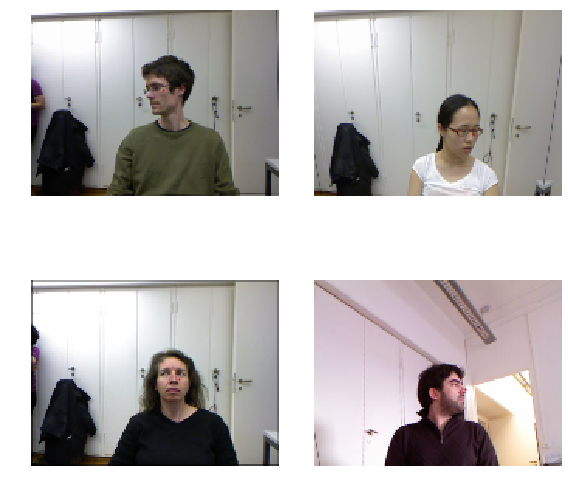

In [24]:
data.show_batch(rows=2)

In [25]:
learner = create_cnn(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 62856589.20it/s]


In [26]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02


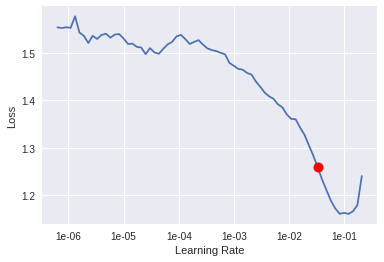

In [29]:
learner.recorder.plot()

In [30]:
from fastai.callbacks import SaveModelCallback
savemodel = SaveModelCallback(learner, name='v1')
# Note to self: got to valid_loss of 0.0031 in 1 epoch/lr=5e-2 (similarly to 0.0037 in original notebook without tfm_y=True and image normalization), then started to overfit
# tfm_y=True: 0.0024 in the 1st epoch though
# Note to self: even without normalization hot to 0.0016 (orig notebook stage-1 is 0.0023)
learner.fit_one_cycle(5, 2e-2, callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.050882,0.005178
2,0.013058,0.001550
3,0.004334,0.000587
4,0.002547,0.001661
5,0.001855,0.000245


Better model found at epoch 1 with val_loss value: 0.005177838262170553.
Better model found at epoch 2 with val_loss value: 0.0015498839784413576.
Better model found at epoch 3 with val_loss value: 0.0005870347376912832.
Better model found at epoch 5 with val_loss value: 0.00024466754985041916.


In [0]:
learner.load('v1');

In [35]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


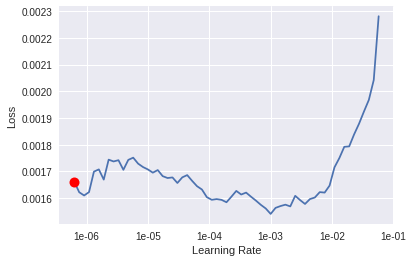

In [36]:
learner.recorder.plot()

In [37]:
savemodel = SaveModelCallback(learner, name='v2')
# Note to self: got to valid_loss of 0.0031 in 1 epoch/lr=5e-2 (similarly to 0.0037 in original notebook without tfm_y=True and image normalization), then started to overfit
# tfm_y=True: 0.0024 in the 1st epoch though
# Note to self: even without normalization hot to 0.0016 (orig notebook stage-1 is 0.0023)
learner.fit_one_cycle(5, slice(1e-10, 1e-7), callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.001664,0.000404
2,0.001692,0.000263
3,0.001644,0.000519
4,0.001674,0.000268
5,0.001779,0.000217


Better model found at epoch 1 with val_loss value: 0.0004040547355543822.
Better model found at epoch 2 with val_loss value: 0.0002631997340358794.
Better model found at epoch 5 with val_loss value: 0.0002168466744478792.


In [0]:
learner.load('v2');

In [43]:
print(learner.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 60, 80]      9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 60, 80]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 60, 80]      0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 30, 40]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 30, 40]      36,864     False     
______________________________________________________________________
BatchNorm2d          [1, 64, 30, 40]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 30, 40]      0          False     
______________________________________________________________

In [0]:
learner.unfreeze()

In [45]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


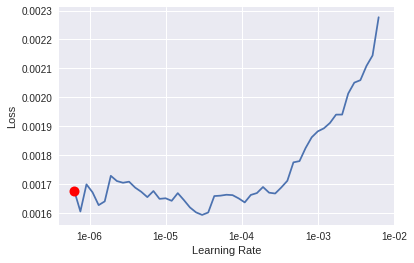

In [46]:
learner.recorder.plot()

In [47]:
savemodel = SaveModelCallback(learner, name='v3')
learner.fit_one_cycle(5, slice(1e-10, 1e-7), callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.001750,0.000470
2,0.001725,0.000352
3,0.001761,0.000339
4,0.001687,0.000383
5,0.001688,0.000298


Better model found at epoch 1 with val_loss value: 0.00046968256356194615.
Better model found at epoch 2 with val_loss value: 0.00035176490200683475.
Better model found at epoch 3 with val_loss value: 0.000339427002472803.
Better model found at epoch 5 with val_loss value: 0.00029781178454868495.


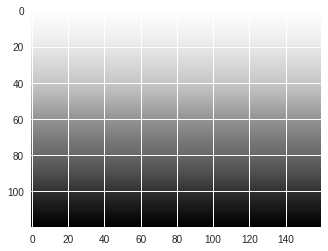

In [39]:
horizontal_gradient = torch.linspace(0, 1, steps=160).unsqueeze(0).repeat((120, 1))
vertical_gradient = torch.linspace(0, 1, steps=120).unsqueeze(1).repeat((1, 160))
plt.imshow(vertical_gradient)

In [0]:
one_batch = data.one_batch()

In [0]:
class CoordConvWrapper2d(nn.Module):
  def __init__(self, o):
    super(CoordConvWrapper2d, self).__init__()
    self.conv = nn.Conv2d(in_channels=o.in_channels + 2,
                          out_channels=o.out_channels,
                          kernel_size=o.kernel_size,
                          stride=o.stride,
                          padding=o.padding,
                          bias=o.bias)
    orig_weights = o.weight.clone()
    batch_size, channels, n_rows, n_cols = orig_weights.shape
    init_magnitude = orig_weights.median() / 10
    additional_weights = torch.zeros((batch_size, 2, n_rows, n_cols))
    additional_weights = additional_weights.data.uniform_(-init_magnitude, init_magnitude).cuda();
    # TODO: can I store both but grad-enable just the new ones at least at first?
    self.conv.weight.data = torch.cat([orig_weights, additional_weights], dim=1)
    self.horizontal_gradient, self.vertical_gradient, self.cached_shape = None, None, None
    
  def forward(self, x):
    batch_size, channels, n_rows, n_cols = x.shape

    if (x.shape != self.cached_shape):
      horizontal_gradient = torch.linspace(0, 1, steps=n_cols).unsqueeze(0).repeat((n_rows, 1)).unsqueeze(0).unsqueeze(0).cuda()
      vertical_gradient = torch.linspace(0, 1, steps=n_rows).unsqueeze(1).repeat((1, n_cols)).unsqueeze(0).unsqueeze(0).cuda()

      # TODO: any use from normalizing to unit mean / std or like to -1,1?
      self.horizontal_gradient = horizontal_gradient.repeat((batch_size,1,1,1))
      self.vertical_gradient = vertical_gradient.repeat((batch_size,1,1,1))
      self.cached_shape = x.shape

    x = torch.cat([x, self.horizontal_gradient, self.vertical_gradient], dim=1)
    return self.conv(x)

In [0]:
learner = create_cnn(data, models.resnet34)

In [0]:
from torchvision.models.resnet import BasicBlock
def walk(model):
  if (type(model) == CoordConvWrapper2d):
    return

  for idx, child in enumerate(model.children()):
    if (type(child) == BasicBlock):
      if (type(child.conv1) != CoordConvWrapper2d):
        child.conv1 = CoordConvWrapper2d(child.conv1)
      if (type(child.conv2) != CoordConvWrapper2d):
        child.conv2 = CoordConvWrapper2d(child.conv2)
      continue
    
    if (type(child) == nn.Conv2d):
      model[idx] = CoordConvWrapper2d(child)
      continue

    walk(child)
      
walk(learner.model)

In [51]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02


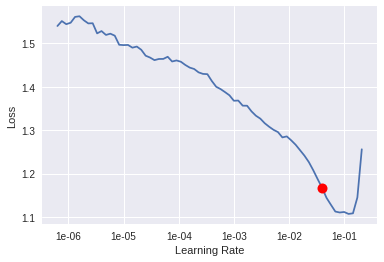

In [52]:
learner.recorder.plot()

In [53]:
savemodel = SaveModelCallback(learner, name='v_coord_1')
learner.fit_one_cycle(5, slice(2e-2), callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.055185,0.009860
2,0.020009,0.003221
3,0.009559,0.001573
4,0.006029,0.000741
5,0.004451,0.001502


Better model found at epoch 1 with val_loss value: 0.009860176593065262.
Better model found at epoch 2 with val_loss value: 0.0032207327894866467.
Better model found at epoch 3 with val_loss value: 0.0015734726330265403.
Better model found at epoch 4 with val_loss value: 0.0007411164697259665.


In [0]:
learner.load('v_coord_1')
learner.unfreeze()

In [55]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06


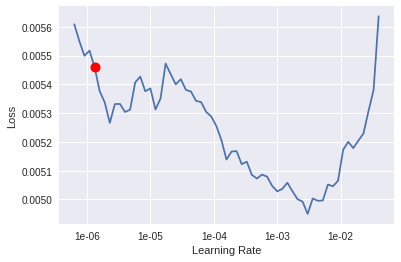

In [56]:
learner.recorder.plot()

In [57]:
savemodel = SaveModelCallback(learner, name='v_coord_2')
learner.fit_one_cycle(5, slice(1e-10, 1e-6), callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.005374,0.000835
2,0.005399,0.000951
3,0.005309,0.000910
4,0.005375,0.001034
5,0.005346,0.000841


Better model found at epoch 1 with val_loss value: 0.000835360202472657.


In [61]:
learner.load('v_coord_2');

Learner(data=ImageDataBunch;

Train: LabelList (15193 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /root/.fastai/data/biwi_head_pose;

Valid: LabelList (485 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /root/.fastai/data/biwi_head_pose;

Test: None, model=Sequential(
  (0): Sequential(
    (0): CoordConvWrapper2d(
      (conv): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, s

In [59]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


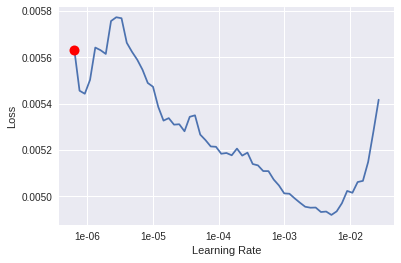

In [60]:
learner.recorder.plot()

In [62]:
# compare this to 0.001688 / 0.000298	without CoordConv, wouldn't say it exactly helped
from fastai.callbacks import *
savemodel = SaveModelCallback(learner, name='v_coord_3')
learner.fit_one_cycle(5, slice(1e-10, 1e-7), callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.005380,0.000826
2,0.005229,0.000786
3,0.005327,0.000741
4,0.005489,0.000958
5,0.005551,0.000782


Better model found at epoch 1 with val_loss value: 0.0008264343487098813.
Better model found at epoch 2 with val_loss value: 0.0007862460915930569.
Better model found at epoch 3 with val_loss value: 0.0007406275835819542.


In [0]:
def magnitude(coord_wrapper):
  coord_imp = coord_wrapper.conv.weight[:,3:,:,:].contiguous().median().item()
  conv_imp = coord_wrapper.conv.weight[:,:3,:,:].contiguous().median().item()
  magnitudes = np.log(np.abs((coord_imp, conv_imp)))
  return magnitudes

In [67]:
magnitude(learner.model[0][0])

array([-26.395155, -18.417508])

In [68]:
# Note to self: fun stuff - most of the things were immediate children :/
def walk(model, indent):
  if (type(model) == CoordConvWrapper2d):
    print(indent + str(magnitude(model)))
    return

  for idx, child in enumerate(model.children()):
    walk(child, indent + "  ")
      
walk(learner.model, "")

    [-26.395155 -18.417508]
        [-22.809007  -6.581411]
        [-12.947534  -7.828438]
        [-9.9263  -7.49706]
        [-11.150622  -6.829515]
        [-10.026403  -6.219899]
        [-12.024187  -5.844724]
        [-8.963254 -6.578993]
        [-8.540018 -6.619222]
        [-7.332    -5.849573]
        [ -7.319031 -11.3335  ]
        [-7.500037 -5.688113]
        [-7.920916 -7.632394]
        [-6.526758 -6.144874]
        [-7.244749 -8.059488]
        [-7.268252 -6.864973]
        [-7.578055 -8.789312]
        [-6.806996 -6.599295]
        [-7.23063  -6.640382]
        [-6.545286 -6.496696]
        [-7.064054 -6.76519 ]
        [-6.538942 -6.170625]
        [-6.962254 -6.915681]
        [-6.470729 -6.034319]
        [-6.803956 -6.353551]
        [-6.55985  -6.256007]
        [-6.589805 -6.925826]
        [-6.870617 -7.981793]
        [-7.15711  -7.402789]
        [-6.266721 -6.100221]
        [-7.438576 -7.994936]
        [-6.185109 -6.620857]
        [-7.588479 -7.143842]


In [0]:
# Note to self: CoordConv didn't help to train faster/better in here. When I added weights to super-fine tuned model in prev run of the notebook - it didn't hurt but didn't help either